In [1]:
import warnings
warnings.simplefilter(action='ignore')
import os
import datetime
import logging
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import folium

os.chdir('..')

from src.config import FOLIUM_CFG
from src.data.arpa.arpa_quality_raw_funcs import ArpaConnect, get_city_sensor_ids
from src.visualization.create_map import display_station_map
from src.visualization.visualize import display_timestamp, display_plotly_timestamp, display_year_on_year_avg_pollutant
from src.data.common_funcs import load_dataset, load_normalized_dataset



In [2]:
arpa = ArpaConnect()
sensor_data = get_city_sensor_ids(arpa=arpa, city='Milano')
m = folium.Map(**FOLIUM_CFG)

Connected with Socrata backend for recent data
Download from Socrata dataset ib47-atvt with kwargs {'where': "comune = 'Milano' and datastop IS NULL", 'order': 'idsensore'}


# How Is covid-19 containment affecting pollutant levels? 
## A short analysis for Milan, Italy

I selected open data from ARPA Lombardia, the regional weather agency, available at sensor level. Here's a map for sensor stations located in the city of Milan.
By clicking on the marker a popup will show which sensors are present on the selected station, and which pollutant is measured by the sensor. 

In [3]:
display_station_map(folium_map=m, sensor_registry=sensor_data)

## NO2 concentrations

In [4]:
selected_sensors = sensor_data.loc[sensor_data['nometiposensore']=='Biossido di Azoto', 'idsensore'].drop_duplicates().tolist()

I started looking at raw data measured by these stations, in particular I focues my attention on NO2, which is the pollutant considered by several weather agencies in satellite images to highlight the COVID-19 effect. Several [news agencies](https://www.euronews.com/2020/03/14/coronavirus-satellite-data-shows-italy-s-pollution-plummet-amid-covid-19-lockdown) published a "before-after comparison like this:

A time series equivalent for Milan data can be visualized as follows,with red and green areas representing the same time range represented into the satellite frames:

In [5]:
raw_data = load_dataset()
selected_raw_data = raw_data[raw_data['idsensore'].isin(selected_sensors)]
last_year_selected_raw_data = selected_raw_data[selected_raw_data['data'].dt.year>=2020]
lines_last_year_selected_raw_data = last_year_selected_raw_data.pivot_table(index='data', columns='idsensore', values='valore').reset_index()
lines_last_year_selected_raw_data['average'] = lines_last_year_selected_raw_data[selected_sensors].mean(axis=1)

loading dataset from C:\Users\aricca\Documents\covid-pollution-effect\data\processed\dataset.pkl


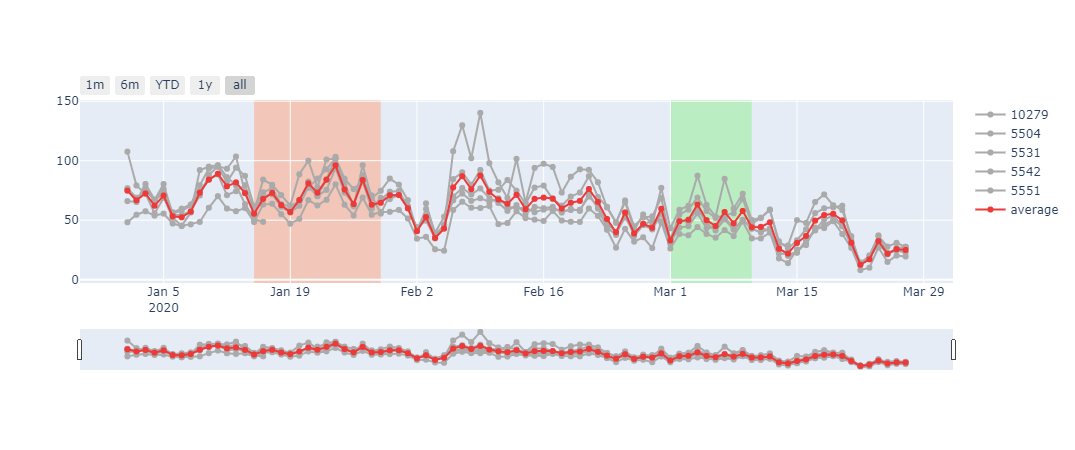

In [6]:
display_plotly_timestamp(lines=lines_last_year_selected_raw_data, color_only_average=True, before_after_areas=True)

Raw data are collected at hourly level, but here daily averages by sensors are plotted. A global average is represented to better visualize the common trend.

A Year on Year (YoY) comparison with 2019 is then plotted on the global average, and the two series do not seem to appear so different:

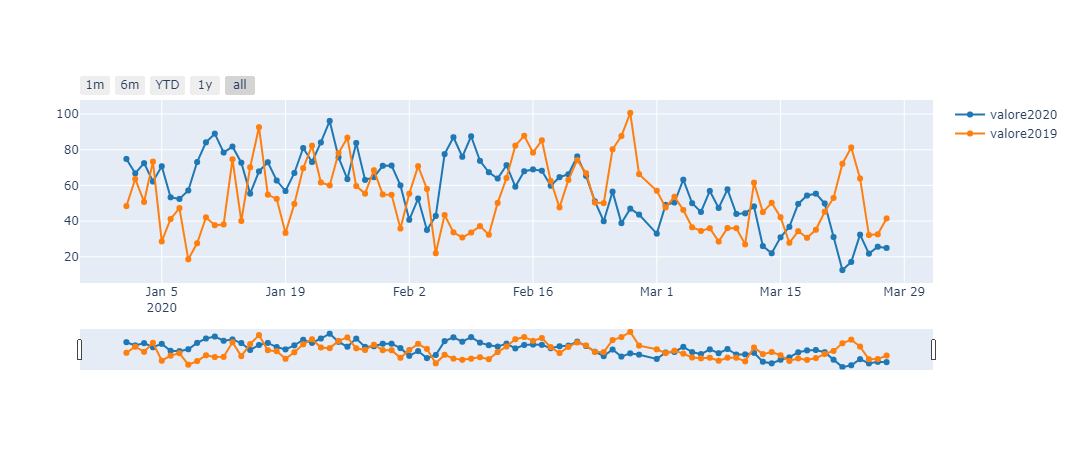

In [7]:
display_year_on_year_avg_pollutant(data=selected_raw_data, comp_year=2019)

Moreover, weekly trends might be also depend on weather conditions: rain, humidity, temperature and wind have a recognized impact on air quality so they must be taken into account to correctly compare pollutant series.
Several research has been conducted to obtain this process, also know as "**weather normalization**". Among the other, I found very useful the analysis made by [Stuart Grange](https://www.researchgate.net/profile/Stuart_Grange2), in particular his R package [rmweater](https://github.com/skgrange/rmweather).
I tried to reproduce the procedure he explained in Python, all my code is available inside this [github repository](https://github.com/ndricca/covid-pollution-effect/). 

Long story short, I obtained daily weather data for Milan and trained a Random Forest model on each sensor using calendar and weather features as covariates.
Then, a set of multiple forecasts is conducted randomly assigning weather and calendar features to each day and aggregating the results. 

Applying this procedure on NO2 data resulted in a more evident decreasing trend, as you can see on the YoY comparison below.
Starting from the beginning of March, the two series are clearly diverging.

In [8]:
norm_data = load_normalized_dataset()
selected_norm_data = norm_data[norm_data['idsensore'].isin(selected_sensors)]
last_year_selected_norm_data = selected_norm_data[selected_norm_data['data'].dt.year>=2020]
lines_last_year_selected_norm_data = last_year_selected_norm_data.pivot_table(index='data', columns='idsensore', values='valore').reset_index()
lines_last_year_selected_norm_data['average'] = lines_last_year_selected_norm_data[selected_sensors].mean(axis=1)

loading normalized dataset from C:\Users\aricca\Documents\covid-pollution-effect\data\processed\normalized_dataset.pkl


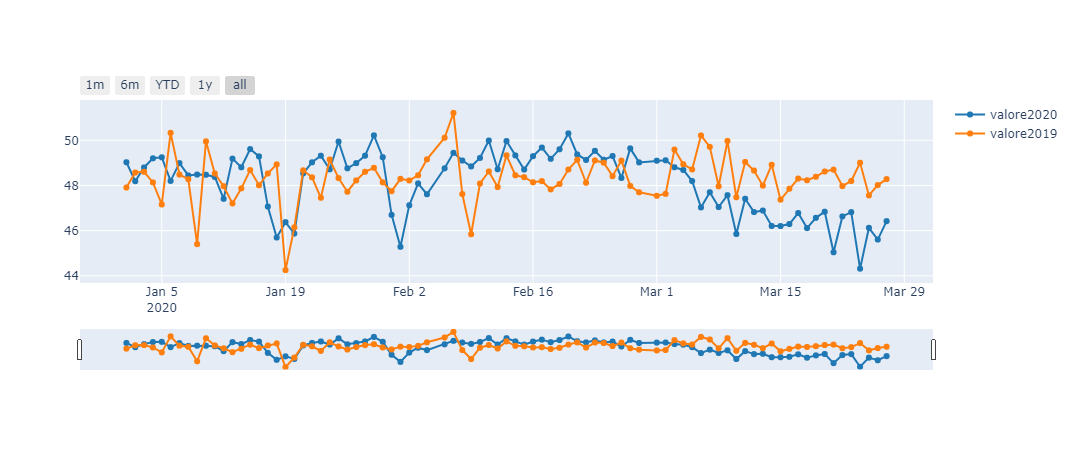

In [9]:
display_year_on_year_avg_pollutant(data=selected_norm_data, comp_year=2019)

In [10]:
## Other pollutant comparison

Comparing normalized series of other pollutants resulted in quite different plots. In practice the other most important pollutants did not shows this kind of divergence. 

This is the result for PM10:

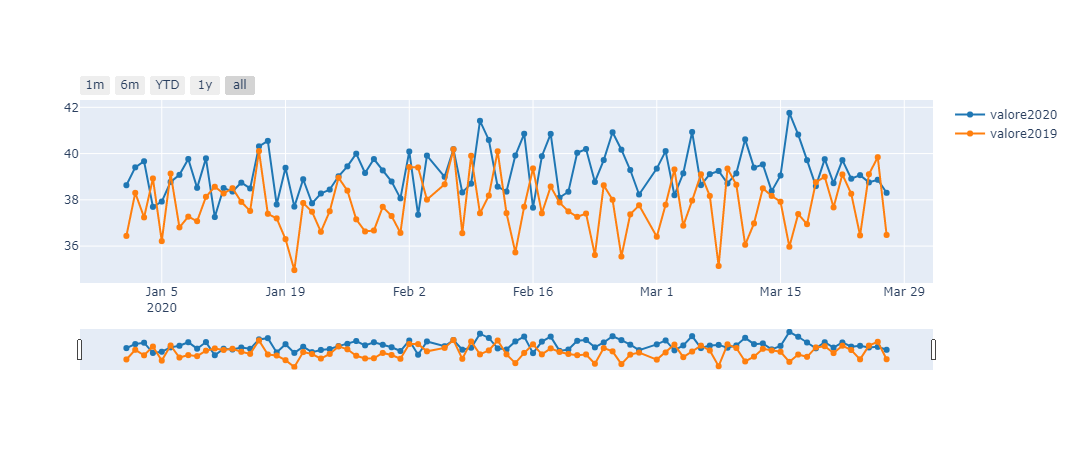

In [11]:
selected_sensors = sensor_data.loc[sensor_data['nometiposensore']=='PM10 (SM2005)', 'idsensore'].drop_duplicates().tolist()
selected_norm_data = norm_data[norm_data['idsensore'].isin(selected_sensors)]
display_year_on_year_avg_pollutant(data=selected_norm_data, comp_year=2019)

This is the result for PM2.5:

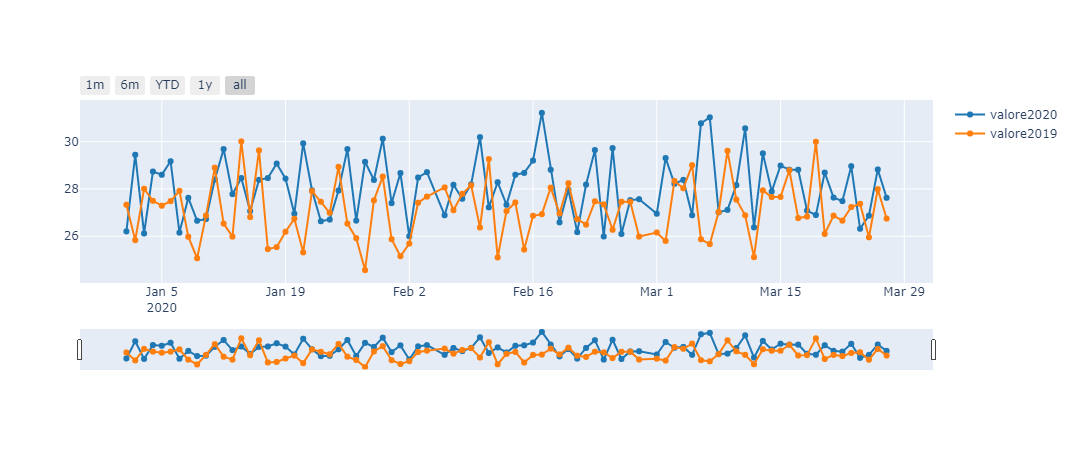

In [12]:
selected_sensors = sensor_data.loc[sensor_data['nometiposensore']=='Particelle sospese PM2.5', 'idsensore'].drop_duplicates().tolist()
selected_norm_data = norm_data[norm_data['idsensore'].isin(selected_sensors)]
display_year_on_year_avg_pollutant(data=selected_norm_data, comp_year=2019)

And finally here's the comparison for CO. 

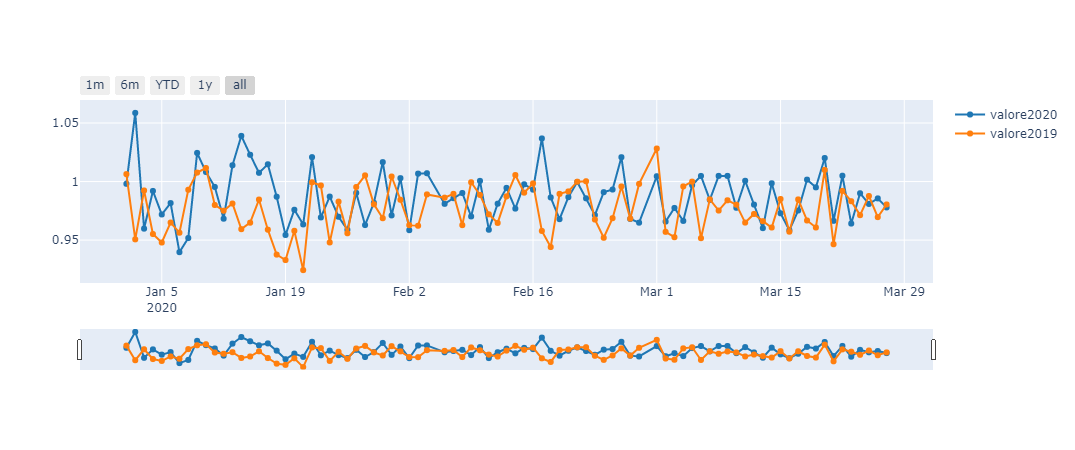

In [13]:
selected_sensors = sensor_data.loc[sensor_data['nometiposensore']=='Monossido di Carbonio', 'idsensore'].drop_duplicates().tolist()
selected_norm_data = norm_data[norm_data['idsensore'].isin(selected_sensors)]
display_year_on_year_avg_pollutant(data=selected_norm_data, comp_year=2019)

More other pollutant can be compared. Inside my repository I published also the code for a very simple streamlit app in which it is possible to choose a pollutant and observe raw and normalized data. 